Tutorials for course ECE1508 Reinforcement Learning at the University of Toronto.

Author: Xiaocan (Bruce) Li

Email: hsiaotsan.li@mail.utoronto.ca

#Recap of last tutorial
In the previous tutorial, we covered how to use DQN for **discrete** action problems. However, DQN cannot solve **continuous** action problems because the action is taken from the argmax of Q values.


#Overview


In this tutorial, we are going to demonstrate how to leverage policy gradient methods for games in discrete action space and games in continuous action spaces.


**Related links:**
* Cart Pole Official Website: https://www.gymlibrary.dev/environments/classic_control/cart_pole/
* Mountain Car Continuous Official Website: https://www.gymlibrary.dev/environments/classic_control/mountain_car/
* Pendulum Official Website: https://www.gymlibrary.dev/environments/classic_control/pendulum/
* OpenAI Leaderboard for Most Games: https://github.com/openai/gym/wiki/Leaderboard#mountaincar-v0

# Import libraries

In [9]:
import gym
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [10]:
# Load files from google drive
# Only run this code if you run this notebook on *Google Colab* to save your training results.
# You can skip this code block if you run elsewhere.
if True:
  import os
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/Projects/ECE1508_RL/Tutorial3_PolicyGradient')
  !ls

Mounted at /content/drive
 models   plots  'Tutorial 3 - Policy Gradient.ipynb'


# Policy Network and Value Network (Actor and Critic)

In [4]:
class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size, env, fc1_dims=128):
        super(ActorCritic, self).__init__()

        self.env = env

        # Input layer
        self.fc1 = nn.Linear(state_size, fc1_dims)

        # Discrete action space. Softmax for ouputting probabilities.
        if isinstance(env.action_space, gym.spaces.Discrete):
            self.action_head = nn.Linear(fc1_dims, action_size)
            self.softmax = nn.Softmax(dim=-1)

        # Continuous action space needs mean and std for action distributions
        if isinstance(env.action_space, gym.spaces.Box):
            self.mu_head = nn.Linear(fc1_dims, action_size)
            self.std_head = nn.Linear(fc1_dims, action_size)

        # State value as the baseline
        self.value_head = nn.Linear(fc1_dims, 1)


    def forward(self, x):
        # Discrete action space
        if isinstance(self.env.action_space, gym.spaces.Discrete):
            x = torch.relu(self.fc1(x))
            action_probs = self.softmax(self.action_head(x))
            state_values = self.value_head(x)
            return action_probs, state_values

        # Continuous action space
        if isinstance(self.env.action_space, gym.spaces.Box):
            x = torch.relu(self.fc1(x))
            action_mean = self.mu_head(x)
            action_std = torch.exp(self.std_head(x))
            state_values = self.value_head(x)
            return action_mean, action_std, state_values


    def save_weights(self, path):
        torch.save(self.state_dict(), path)

    def load_weights(self, path):
        self.load_state_dict(torch.load(path))

# Episode generating function

In [5]:
def generate_episode(env, policy):
    state = env.reset().squeeze()
    log_probs = []
    state_values = []
    rewards = []
    masks = []
    done = False

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        # Discrete action space
        if isinstance(env.action_space, gym.spaces.Discrete):
            # Compute probability for each discrete action
            probs, state_value = policy(state)
            # For discrete action space, use multi-nomial distribution
            action_distribution = torch.distributions.Categorical(probs)
            action = action_distribution.sample()
            log_prob = action_distribution.log_prob(action)
            action = action.item()

        # Continuous action space
        elif isinstance(env.action_space, gym.spaces.Box):
            # Compute action mean and std for the continuous action
            action_mean, action_std, state_value = policy(state)
            # For continuous action space, use normal distribution
            action_distribution = torch.distributions.Normal(action_mean, action_std)
            action = action_distribution.sample()
            log_prob = action_distribution.log_prob(action)
            action = action.detach().numpy()

        next_state, reward, done, _ = env.step(action)

        log_probs.append(log_prob)
        state_values.append(state_value)
        rewards.append(torch.tensor([reward], dtype=torch.float32))

        # Masks for handling the terminal state reward = 0
        masks.append(torch.tensor([1-done], dtype=torch.float32))

        state = next_state.squeeze()
    return log_probs, state_values, rewards, masks



def compute_returns(rewards, masks, gamma=0.99):
    G = torch.tensor([0.0])
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * G * masks[step]
        returns.insert(0, G)
    return returns

# Policy evaluating function

In [6]:
# Evaluate a policy
def evaluate_policy(env, policy, episodes=10, render=False):
    total_rewards = []
    for _ in range(episodes):
        state = env.reset().squeeze()
        done = False
        episode_reward = 0

        while not done:
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():  # No need to calculate gradients during evaluation

                # Discrete action space
                if isinstance(env.action_space, gym.spaces.Discrete):
                    probs, _ = policy(state)
                    action = torch.argmax(probs).item()  # Select action with highest probability

                # Continuous action space
                elif isinstance(env.action_space, gym.spaces.Box):
                    mu, std, _ = policy(state)
                    action = mu.numpy()  # Use the mean of the distribution as the action

            next_state, reward, done, _ = env.step(action)
            if render:
                env.render()
            state = next_state.squeeze()

            episode_reward += reward
        total_rewards.append(episode_reward)
    average_reward = sum(total_rewards) / episodes
    # print(f"Average Reward over {episodes} episodes: {average_reward}")
    env.close()
    return average_reward

# Policy gradient algorithm with Advantage

In [7]:
def train_actor_critic(env, policy, optimizer, episodes, gamma=0.99, evaluation_interval=50, save_path='models/model.pth'):
    best_reward = -np.inf
    episode_rewards = []

    for episode in range(episodes):
        log_probs, state_values, rewards, masks = generate_episode(env, policy)
        episode_rewards.append(sum(rewards))

        returns = compute_returns(rewards, masks, gamma)

        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        state_values = torch.cat(state_values)

        advantage = returns - state_values

        # - A * log pi. Quiz: Why negative sign?
        actor_loss = -(log_probs * advantage).mean()

        # Mean Squared Error for critic loss
        critic_loss = advantage.pow(2).mean()

        optimizer.zero_grad()
        (actor_loss + critic_loss).backward()
        optimizer.step()

        # Evaluate the policy periodically
        if episode % evaluation_interval == 0:
            average_reward = evaluate_policy(env, policy, episodes=evaluation_interval)
            print(f'Episode {episode}: Evaluation Average Reward: {average_reward}')
            if average_reward > best_reward:
                best_reward = average_reward
                print(f"New best reward {best_reward} found, saving model.")
                policy.save_weights(save_path)


    episode_rewards = np.array(episode_rewards)
    smooth_rewards = np.zeros(len(episode_rewards) - 50)
    # average over last 50 episodes
    for t in range(len(episode_rewards)-50):
        smooth_rewards[t] = np.mean(episode_rewards[-50+t:t])


    plt.figure(figsize=(10, 5))
    plt.plot(smooth_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Training Rewards')
    plt.savefig(f'plots/BPG_{env.spec.id}.png')
    plt.show()

    return policy

# CartPole-v0: discrete action space

Episode 0: Evaluation Average Reward: 9.5
New best reward 9.5 found, saving model.
Episode 50: Evaluation Average Reward: 9.32
Episode 100: Evaluation Average Reward: 9.32
Episode 150: Evaluation Average Reward: 9.24
Episode 200: Evaluation Average Reward: 45.72
New best reward 45.72 found, saving model.
Episode 250: Evaluation Average Reward: 63.26
New best reward 63.26 found, saving model.
Episode 300: Evaluation Average Reward: 32.7
Episode 350: Evaluation Average Reward: 61.22
Episode 400: Evaluation Average Reward: 150.66
New best reward 150.66 found, saving model.
Episode 450: Evaluation Average Reward: 95.2
Episode 500: Evaluation Average Reward: 51.02
Episode 550: Evaluation Average Reward: 106.86
Episode 600: Evaluation Average Reward: 177.96
New best reward 177.96 found, saving model.
Episode 650: Evaluation Average Reward: 113.82
Episode 700: Evaluation Average Reward: 144.36
Episode 750: Evaluation Average Reward: 166.0
Episode 800: Evaluation Average Reward: 163.24
Episode

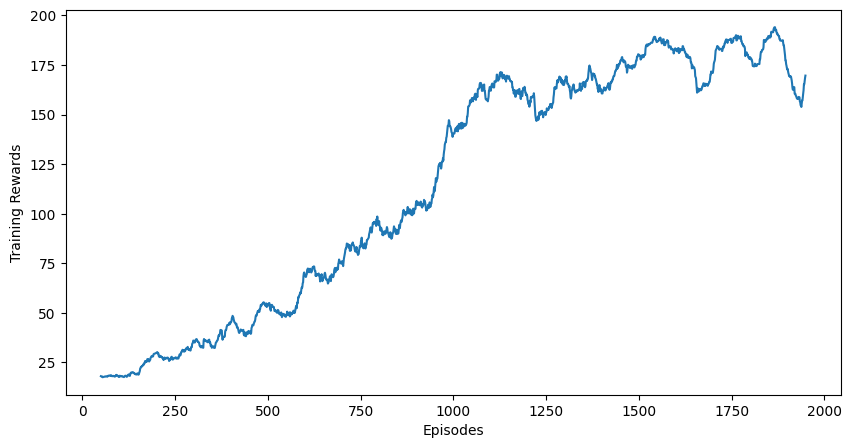

In [69]:
# Initialize environment and model
env = gym.make('CartPole-v0')
env.seed(42)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
policy = ActorCritic(state_size, action_size, env, fc1_dims=128)
optimizer = optim.Adam(policy.parameters(), lr=0.001)

# Train the policy
trained_policy = train_actor_critic(env, policy, optimizer, episodes=2000, save_path='models/BPG_'+ env.spec.id)

# Evaluate the trained policy
average_reward = evaluate_policy(env, trained_policy, episodes=10)


## Load & Evaluate the trained policy

In [70]:
env = gym.make('CartPole-v0')

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
policy = ActorCritic(state_size, action_size, env)
policy.load_weights('models/BPG_CartPole-v0')
policy.eval()

average_reward = evaluate_policy(env, policy, episodes=100, render=False)
print(average_reward)

200.0


# MountainCarContinuous-v0: continuous action space

MountainCarContinuous-v0 defines "solving" as getting average reward of 90.0 over 100 consecutive trials.

The trained policy usually make the car easily stuck in the valley, due to the high sparsity of reward distribution.

Try redesign the reward to make our life easier.

Tune hyperparameters to make it work, good luck!

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/envs/classic_control/continuous_mountain_car.py:171: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward -= math.pow(action[0], 2) * 0.1
/usr/local/lib/python3.10/dist-packages

Episode 0: Evaluation Average Reward: -0.31999701514689877
New best reward -0.31999701514689877 found, saving model.
Episode 50: Evaluation Average Reward: -0.05115555008537018
New best reward -0.05115555008537018 found, saving model.
Episode 100: Evaluation Average Reward: -0.09888319089505541
Episode 150: Evaluation Average Reward: -0.01923045984482685
New best reward -0.01923045984482685 found, saving model.


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


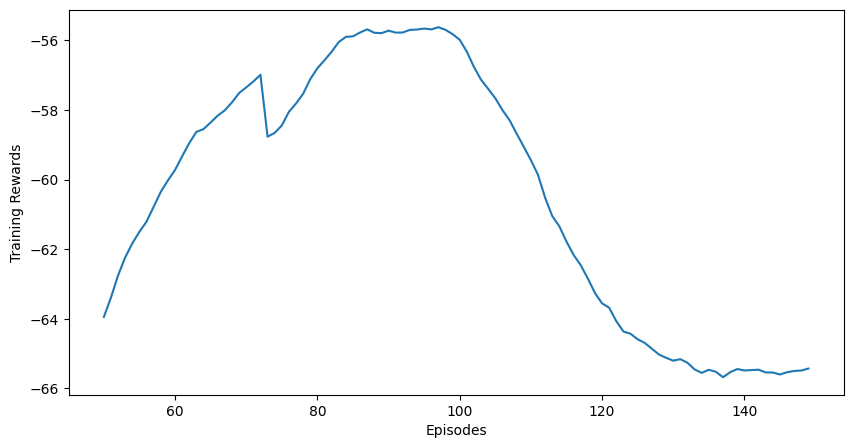

In [12]:

# Initialize environment and model
env = gym.make('MountainCarContinuous-v0')
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0] if isinstance(env.action_space, gym.spaces.Box) else env.action_space.n
policy = ActorCritic(state_size, action_size, env)
optimizer = optim.Adam(policy.parameters(), lr=0.001)

# Train the policy
trained_policy = train_actor_critic(env, policy, optimizer, episodes=200, save_path='models/BPG_'+ env.spec.id)

# Evaluate the trained policy
average_reward = evaluate_policy(env, trained_policy, episodes=10, render=False)


# Pendulum-v1: continuous action space

Try to reach a reward of -200.

Tune hyperparameters to make it work, good luck!

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:260: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'numpy.ndarray'>
  logger.warn(


Episode 49: Evaluation Average Reward: [-1369.6434]
New best reward [-1369.6434] found, saving model.
Episode 99: Evaluation Average Reward: [-1431.47]
Episode 149: Evaluation Average Reward: [-1339.1016]
New best reward [-1339.1016] found, saving model.
Episode 199: Evaluation Average Reward: [-1376.5563]
Episode 249: Evaluation Average Reward: [-1423.9058]
Episode 299: Evaluation Average Reward: [-1487.7756]
Episode 349: Evaluation Average Reward: [-1432.0552]
Episode 399: Evaluation Average Reward: [-1613.418]
Episode 449: Evaluation Average Reward: [-1438.3214]
Episode 499: Evaluation Average Reward: [-1443.9603]
Episode 549: Evaluation Average Reward: [-1461.8059]
Episode 599: Evaluation Average Reward: [-1542.5703]
Episode 649: Evaluation Average Reward: [-1518.2075]
Episode 699: Evaluation Average Reward: [-1531.2661]
Episode 749: Evaluation Average Reward: [-1438.9958]
Episode 799: Evaluation Average Reward: [-1512.4388]
Episode 849: Evaluation Average Reward: [-1396.4768]
Epis

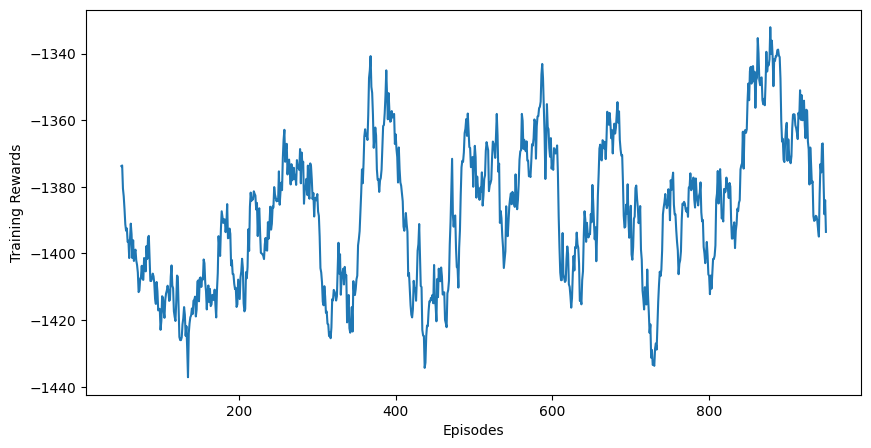

In [14]:

# Initialize environment and model
env = gym.make('Pendulum-v1', g=9.81)
env = gym.wrappers.TimeLimit(env, max_episode_steps=200)

state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0] if isinstance(env.action_space, gym.spaces.Box) else env.action_space.n
policy = ActorCritic(state_size, action_size, env)
optimizer = optim.Adam(policy.parameters(), lr=0.001)

# Train the policy
trained_policy = train_actor_critic(env, policy, optimizer, episodes=1000, save_path='models/BPG_'+ env.spec.id)

# Evaluate the trained policy
average_reward = evaluate_policy(env, trained_policy, episodes=10, render=False)


# Conclusion


In this tutorial, we explored the Actor-Critic method, an important approach in reinforcement learning that combines the benefits of both policy-based and value-based approaches. As we wrap up, let's highlight some of the key takeaways:

**Integration of Baseline for Variance Reduction:**

The Actor-Critic method introduces a baseline function, typically the state value function, which helps to reduce the variance of the policy gradient estimates. As long as the baseline function is independent of the action, the policy gradient is unbiased. This approach stabilizes learning by providing a reference point (the critic) against which the policy's actions (the actor) can be evaluated, improving the efficiency of the learning process.

**Continuous and Discrete Action Spaces:**

Actor-Critic frameworks are versatile, applicable to both continuous and discrete action spaces, making them suitable for a wide range of problems from robotic control (continuous actions) to game playing (discrete actions). The method’s flexibility stems from its ability to model the policy and value functions as neural networks that can output probabilities for discrete actions or mean and variance for continuous actions.

**Separation of Policy and Value Estimation:**

By decoupling the policy and value function estimations, Actor-Critic methods can leverage the strengths of both: using the critic to assess the quality of actions taken by the actor, and updating the policy based on this feedback. This separation allows for more flexible and potentially more powerful learning dynamics compared to methods that only estimate a value function or solely optimize a policy.

